## Instalación de librerías
Primero instalamos las librerías que nos harán falta. En caso de necesitar otras librerías cuya necesidad de instalación surja más adelante, en el desarrollo del proyecto, deberíamos traerlas aquí y correr de nuevo esta celda, de modo que todos los requerimientos estén disponibles en un solo punto. A pesar de contar con la posibilidad de grabar las librerías instaladas mediante pip freeze > requirements.txt creemos que es preferible tener presente cuáles son las librerías realmente instaladas en lugar de todos los módulos requeridos por las dependencias propias de las librerías originales.

Además, esta forma de trabajo nos permite mantener un registro de los pasos a realizar para el desarrollo en cualquier otra plataforma. La única librería instalada luego de generar el entorno virtual será:

- $ pip install jupyter

Luego, como podemos observar, instalamos versiones específicas de numpy, tensorflow y sci-kit. Esto es debido a las compatilidades cruzadas con la plataforma CUDA (Computer Unified Device Architecture) que se encarga de la gestión de cómputos en paralelo y de brindar una API (Application Programming Interface) para la utilización de placas GPU (Graphic Processing Unit).

In [1]:
!pip install numpy==1.23.5
!pip install tensorflow==2.12
!pip install matplotlib
!pip install scikit-image==0.20.0

## Importamos las librerías
Una vez instaladas las librerías en el entorno virtual, las importamos para que estén disponibles en el espacio de trabajo de la notebook. Las impresiones agregadas sirven para chequear que las versiones de tensorflow y numpy sean las correctas para la compatibilidad con la versión 11.8 de CUDA. Esto se trata de versiones cruzadas que son compatibles entre sí. No necesariamente esta compatibilidad es cumplida por las últimas versiones de cada librería y por ello es que debemos ser tan específicos con estos valores. Generalmente, al ejecutar esta celda también aparecerán algunos *warnings*. Estos podrían evitarse con una pesquisa aún más detallada de las versiones de librerías y su compatibilidad cruzada.

In [2]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np, tensorflow as tf

#import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import json
import random
#import numpy as np

# para limpiar memoria
from tensorflow.keras import backend as K
import gc

from PIL import Image as im


print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

2025-06-05 17:18:30.669777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 17:18:31.325287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 17:18:31.328829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 17:18:32.585506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NumPy: 1.23.5
TensorFlow: 2.12.0
GPUs disponibles: []


## Fragmentación y defragmentación de imágenes
Para poder realizar la captura de una imagen, fragmentarla, pasar los fragmentos por la red neuronal, obtener la imagen comprimida y poder guardar en archivos la reconstrucción de la imagen comprimida, la imagen comprimida y la reconstrucción de la fragmentación de la imagen original, necesitaremos algunas funciones que se desarrollan en la siguiente celda.

In [3]:
# Función para conversión de imágenes RGB a escala de grises
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

# Función para fragmentar una imagen
def split_image(gray_raw_image, vertical_fragment_size, horizontal_fragment_size):
    '''
    Argumentos:
       np.array: gray_raw_image. Imagen en formato np.array, con valores entre 0 y 255 (escala de grises)
       int: vertical_fragment_size. Tamaño vertical (filas) de los fragmentos.
       int: horizontal_fragment_size. Tamaño horizontal (columnas) de los fragmentos.
       
    Devuelve:
       list[list]: fragmented_images_list. Lista de listas de fragmentos de imagen. En 
                   fragmented_images_list[i][j] tenemos filas y columnas de los fragmentos.
                   El tipo es numpy.ndarray y los subíndices identifican:

                       [cant_filas_fragmentos][cant_cols_fragmentos][filas_por_frag][cols_por_frag]
    '''
    
    height, width = gray_raw_image.shape  
    
    # Dejamos un margen de al menos 8 píxeles por lado (16 píxeles en total) y tomamos el centro de la imagen
    # para calcular la cantidad de filas y columnas de fragmentos de tamaño fragment_size.
    border_width = 16
    final_height = height - border_width
    final_width = width - border_width
    number_vertical_fragments = int(final_height / vertical_fragment_size)
    number_horizontal_fragments = int(final_width / horizontal_fragment_size)
    vertical_half_slack = int((final_height - number_vertical_fragments * vertical_fragment_size) / 2)
    horizontal_half_slack = int((final_width - number_horizontal_fragments * horizontal_fragment_size) / 2)

    initial_image_point_x = int(border_width / 2) + horizontal_half_slack
    initial_image_point_y = int(border_width / 2) + vertical_half_slack

    # print(f'final_height, final_width: {final_height}, {final_width}')
    # print(f'number_vertical_fragments, number_horizontal_fragments: {number_vertical_fragments}, {number_horizontal_fragments}')

    fragmented_images_list = []
    for i in range(number_vertical_fragments):                 # Filas (y)
        for j in range(number_horizontal_fragments):           # Columnas (x)
            inf_limit_y = initial_image_point_y + i * vertical_fragment_size
            sup_limit_y = initial_image_point_y + (i + 1) * vertical_fragment_size
            inf_limit_x = initial_image_point_x + j * horizontal_fragment_size
            sup_limit_x = initial_image_point_x + (j + 1) * horizontal_fragment_size
            # print(f'la concha: {inf_limit_y}, {sup_limit_y}, {inf_limit_x}, {sup_limit_x}')
            gray_raw_image_fragment = gray_raw_image[
                inf_limit_y : sup_limit_y,
                inf_limit_x : sup_limit_x 
            ]

            gray_raw_image_fragment_uint8 = gray_raw_image_fragment.astype(np.uint8)

            # print(f'i, j: {i}, {j}: {gray_raw_image_fragment_uint8}')

            if j == 0:
                fragmented_images_list.append([gray_raw_image_fragment_uint8])
            else:
                fragmented_images_list[i].append(gray_raw_image_fragment_uint8)
                
    # print(f'fr_im_list: {fragmented_images_list}')
    return np.array(fragmented_images_list)
    # return 1

# Función para reconstruir una imagen
def reconstruct_image(fragmented_gray_image):
    frag_rows, frag_cols, frag_rows_size, frag_cols_size = fragmented_gray_image.shape

    reconstructed_image = np.zeros((frag_rows * frag_rows_size, frag_cols * frag_cols_size), dtype=np.uint8)

    for i in range(frag_rows):
        for j in range(frag_cols):
            reconstructed_image[
                i * frag_rows_size : (i + 1) * frag_rows_size, 
                j * frag_cols_size : (j + 1) * frag_cols_size
            ] = fragmented_gray_image[i][j][:][:]

    return reconstructed_image


# Función para comprimir y reconstruir una imagen con la red neuronal
def predict_image(fragmented_gray_image: np.ndarray, full_model: Model, hidden_model: Model):
    frag_rows, frag_cols, frag_rows_size, frag_cols_size = fragmented_gray_image.shape

    output_image_array = []
    compressed_output_image_array = []
    for i in range(frag_rows):
        for j in range(frag_cols):
            input_image_fragment = fragmented_gray_image[i][j]

            output_image_fragment = full_model.predict(input_image_fragment.reshape(-1, 784), verbose=0)
            compressed_output_image_fragment = hidden_model.predict(input_image_fragment.reshape(-1, 784), verbose=0)

            output_image_array.append(output_image_fragment)
            compressed_output_image_array.append(compressed_output_image_fragment)

            if (i+1) * (j+1) % 500 == 0:
                print(f"i: {i}, j: {j}")

    x_output_nparray = np.array(output_image_array)
    x_compressed_output_nparray = np.array(compressed_output_image_array)
    
    print(f"shape del output: {x_output_nparray.shape}")
    print(f"shape del compressed: {x_compressed_output_nparray.shape}")

    return x_output_nparray, x_compressed_output_nparray

## Entrenamiento de los modelos
A continuación entrenamos los modelos para fragmentos de 28x28 y 40x40. Son redes con 784 o 1600 "neuronas" en la capa de entrada. La capa oculta es de 16 neuronas (y por lo tanto los factores de compresión son 784/16 a 1 y 1600/16 a 1 (en este último se aproxima a la capacidad de compresión de la primera etapa del sistema visual, en la retina, al pasar la información por el nervio óptico.

In [4]:
# Ahora queremos cargar un conjunto de imágenes de entrenamiento y entrenar una red por pasos, de modo que podamos tomar la salida
# de la capa intermedia y tomar eso como imagen comprimida

# Tamaño de los fragmentos
vertical_fragment_size_list = [28] # , 40]
horizontal_fragment_size_list = [28] # , 40]

# Vamos a entrenar 5 redes para cada conjunto de entrenamiento, con 5 semillas distintas
random_seeds = [100] # , 200, 300, 400, 500]


# Veamos si tenemos un dispositivo GPU para utilizar
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Tenemos una GPU! :)")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No vemos que esté configurada una GPU... :(")

# Path de los directorios de archivos de entrada con conjuntos de entrenamiento y salida con modelos de keras
path_input_dir = "/home/javier/Documentos/Laburo/Universidad/Docencia/Materias/PyProjects/imagesCompression/000_already_splitted_images/"
path_output_dir = "/home/javier/Documentos/Laburo/Universidad/Docencia/Materias/PyProjects/imagesCompression/000_keras_models/"


# Utilizamos los archivos de training para entrenar las redes en sus dos variantes
for i in range(len(vertical_fragment_size_list)):
    vertical_fragment_size = vertical_fragment_size_list[i]
    horizontal_fragment_size = horizontal_fragment_size_list[i]
    
    # Tendremos 5 redes 
    for j in range(1): # 5):

        # sufix file name 
        sufix_file_name = "_" + str(j+1) + "_data_" + str(vertical_fragment_size) + "x" + str(horizontal_fragment_size)

        # Cargamos los datos de entrenamiento
        training_file_name = path_input_dir + "training" + sufix_file_name + ".npy"
        testing_file_name = path_input_dir + "testing" + sufix_file_name + ".npy"
        x_training_data = np.load(training_file_name)
        x_testing_data = np.load(testing_file_name)

        '''
            imprimir las imágenes en archivo... y luego los filtros en otro archivo, para cada red entrenada y posiblemente
            otras yerbas, quizá al estilo de un informe por cada red
        '''

        # Debemos desenvolver las dimensiones de los data_files
        images_numb, rows_numb, cols_numb, vert_frag_size, hor_frag_size = x_training_data.shape
        images_test_numb, rows_test_numb, cols_test_numb, vert_frag_test_size, hor_frag_test_size = x_testing_data.shape

        # Ahora damos forma a los datos de entrenamiento
        x_training_data_reshaped = x_training_data.reshape(
            images_numb * rows_numb * cols_numb,
            vert_frag_size * hor_frag_size
        )
        x_training_data_reshaped = x_training_data_reshaped.astype("float16") / 255.0

        # ...y a los datos de testeo
        x_testing_data_reshaped = x_testing_data.reshape(
            images_test_numb * rows_test_numb * cols_test_numb,
            vert_frag_test_size * hor_frag_test_size
        )
        x_testing_data_reshaped = x_testing_data_reshaped.astype("float16") / 255.0

        print(f"x_training_data_reshaped.shape: {x_training_data_reshaped.shape}")
        print(f"x_training_data_reshaped.dtype: {x_training_data_reshaped.dtype}")
        # assert False

        for random_seed in random_seeds:

            # Fijar semilla
            os.environ['TF_DETERMINISTIC_OPS'] = '1'
            random.seed(random_seed)
            np.random.seed(random_seed)
            tf.random.set_seed(random_seed)
            seed_str = '_seed_' + str(random_seed)
            
            
            # Para comenzar con el entrenamiento, configuramos la precisión mixta para que los datos no ocupen tanto espacio
            # mientras entrenamos la red neuronal
            mixed_precision.set_global_policy('mixed_float16')
    
            # Ahora definimos las capas por separado para poder realizar dos modelos:
            #    Uno completo al que llamaremos "full_model"
            #    Otro intermedio que nos permita ver las capas ocultas al que llamaremos "hiden_model"
            hidden_layer_neurons_number = 16
            input_layer = Input(shape = (vertical_fragment_size * horizontal_fragment_size,), name = "entrada")
            hidden_layer = Dense(hidden_layer_neurons_number, activation = "relu", name = "oculta")(input_layer)
            output_layer = Dense(vertical_fragment_size * horizontal_fragment_size, name = "salida")(hidden_layer)
    
            # Definimos el modelo completo
            full_model = Model(inputs = input_layer, outputs = output_layer)
    
            # Compilamos el modelo
            optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam())
            full_model.compile(optimizer = optimizer,
                               loss = tf.keras.losses.MeanSquaredError(reduction = "sum_over_batch_size",
                                                                       name = "mean_squared_error"))
                                                                       # dtype = None))
            # Vemos la arquitectura
            full_model.summary()
    
            '''
            MEDIMOS EL TIEMPO
            '''
            print(f"\n\nEstamos entrenando el modelo: {path_output_dir + 'full_model' + sufix_file_name + seed_str + '.keras'}\n\n")

            # Monitoreamos la memoria libre antes del entrenamiento
            if len(physical_devices) > 0:
                gpu_memory_before = tf.config.experimental.get_memory_info('GPU:0')
                print(f"[ANTES] Memoria libre en GPU: {gpu_memory_before['current'] / (1024**2):.2f} MiB")

            
            # start time
            start_time = time.time()
            
            # Realizamos el entrenamiento del modelo
            training_full_model = full_model.fit(x_training_data_reshaped, x_training_data_reshaped, epochs = 5)
    
            # end_time
            end_time = time.time()
    
            # Tiempo total
            total_time_to_train_the_model = end_time - start_time
    
            print(f"Tiempo total de entrenamiento: {total_time_to_train_the_model}")
            '''
            FIN DE MEDICIÓN DE TIEMPO
            '''

            # Y después del entrenamiento volvemos a monitorear
            # Después del entrenamiento: ver memoria libre
            if len(physical_devices) > 0:
                gpu_memory_after = tf.config.experimental.get_memory_info('GPU:0')
                print(f"[DESPUÉS] Memoria libre en GPU: {gpu_memory_after['current'] / (1024**2):.2f} MiB")

            '''
            NO, NO VAMOS A GRAFICAR NADA!
            
            # Mostramos el resultado del entrenamiento
            plt.xlabel("#Época")
            plt.ylabel("Magnitud de pérdida")
            plt.title("training_history" + sufix_file_name + seed_str)
            plt.plot(training_full_model.history["loss"])
            '''
            
            # Grabamos el modelo y su historia

            # Antes de grabar el modelo, como lo haremos en .keras, vamos a hacer un predict con un 
            # dummy para que se "construya" el grafo antes de guardar el modelo
            _ = full_model.predict(np.zeros((1,784), dtype=np.float16))
            
            full_model.save(path_output_dir + "full_model" + sufix_file_name + seed_str + ".keras")
            history_path = path_output_dir + "training_history" + sufix_file_name + seed_str + ".json"
            with open(history_path, "w") as f:
                json.dump(training_full_model.history, f)
            
                
            # Asignamos el modelo oculto
            hidden_model = Model(inputs = full_model.input, outputs = hidden_layer)
    
            # Grabamos el modelo oculto

            # Para el hidden_model hacemos lo mismo, antes de grabarlo. Es decir, usamos un dummy
            _ = hidden_model.predict(np.zeros((1,784), dtype=np.float16))
            
            hidden_model.save(path_output_dir + "hidden_model" + sufix_file_name + seed_str + ".keras")

            # Mantenemos limpia la memoria
            # Primero elimino referencias a los modelos
            del full_model
            del hidden_model
            del training_full_model

            # Luego fuerzo la limpieza del backend de Keras
            # tf.keras.backend.clear_session()
            K.clear_session()

            # Finalmente fuerzo la recolección de basura
            gc.collect()

            # Ahora cargamos de nuevo los modelos desde archivos: queremos ver que funcione, evaluarlo y 
            # mostrar el resultado de una predicción directamente sobre una foto real tomada del conjunto
            # de testeo

            full_model_loaded = tf.keras.models.load_model(path_output_dir + "full_model" + sufix_file_name + seed_str + ".keras")
            full_model_loaded.build((None, 784))

            hidden_model_loaded = tf.keras.models.load_model(path_output_dir + "hidden_model" + sufix_file_name + seed_str + ".keras")
            hidden_model_loaded.build((None, 784))

            # A continuación hacemos la evaluación del modelo sobre el conjunto completo de testeo

            testing_results = full_model_cargado.evaluate(x_testing_data_reshaped, x_testing_data_reshaped)

            print(f"Resultados\nTest loss: {testing_results}")

            


No vemos que esté configurada una GPU... :(
x_training_data_reshaped.shape: (612480, 784)
x_training_data_reshaped.dtype: float16
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 784)]             0         
                                                                 
 oculta (Dense)              (None, 16)                12560     
                                                                 
 salida (Dense)              (None, 784)               13328     
                                                  

2025-06-05 17:19:11.070432: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920737280 exceeds 10% of free system memory.
2025-06-05 17:19:18.989320: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920737280 exceeds 10% of free system memory.
2025-06-05 17:19:19.916077: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920737280 exceeds 10% of free system memory.
2025-06-05 17:19:21.008376: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1920737280 exceeds 10% of free system memory.
2025-06-05 17:19:22.138516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [612480,784]
	 [[{{node Placeholder/_10}}]]
2025-06-05 17:19:22.139362: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

Epoch 1/5
19140/19140 [==============================] - 186s 10ms/step - loss: 0.0015
Epoch 2/5
19140/19140 [==============================] - 191s 10ms/step - loss: 0.0011
Epoch 3/5
19140/19140 [==============================] - 198s 10ms/step - loss: 0.0011
Epoch 4/5
19140/19140 [==============================] - 202s 11ms/step - loss: 0.0010
Epoch 5/5
19140/19140 [==============================] - 200s 10ms/step - loss: 0.0010
Tiempo total de entrenamiento: 994.9379880428314
1/1 [==============================] - 0s 44ms/step


2025-06-05 17:35:39.852251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,784]
	 [[{{node Placeholder/_10}}]]
2025-06-05 17:35:39.852519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,784]
	 [[{{node Placeholder/_10}}]]
2025-06-05 17:35:39.991178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [

NameError: name 'full_model_cargado' is not defined

## Probamos las funciones para imágenes
Tenemos las siguientes funciones definidas:


In [13]:
print(testing_results)

0.0008936752565205097


In [18]:
# Por ahora por probar
#x_testing_reconstructed = reconstruct_image(x_testing_data[0])
print(type(full_model_cargado))

<class 'keras.engine.functional.Functional'>


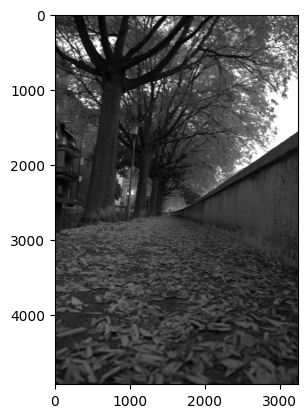

In [17]:
x_testing_reconstructed.shape

plt.imshow(x_testing_reconstructed, cmap='gray')

In [44]:
import os
import sys
import ctypes
import tensorflow as tf

def suppress_cpp_stderr():
    """
    Redirige el stderr de bajo nivel (usado por el backend C++ de TensorFlow) a /dev/null
    """
    libc = ctypes.CDLL(None)
    devnull = os.open(os.devnull, os.O_WRONLY)
    libc.dup2(devnull, 2)  # 2 = stderr

# Primero redirigimos stderr del backend C++
suppress_cpp_stderr()

# Luego silenciamos logs de TensorFlow desde Python (por si acaso)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

imagen_predicha, imagen_comprimida = predict_image(x_testing_data[0], full_model_loaded, hidden_model_loaded)

i: 4, j: 99
i: 9, j: 49
i: 9, j: 99
i: 14, j: 99
i: 19, j: 24
i: 19, j: 49
i: 19, j: 74
i: 19, j: 99
i: 24, j: 19
i: 24, j: 39
i: 24, j: 59
i: 24, j: 79
i: 24, j: 99
i: 29, j: 49
i: 29, j: 99
i: 34, j: 99
i: 39, j: 24
i: 39, j: 49
i: 39, j: 74
i: 39, j: 99
i: 44, j: 99
i: 49, j: 9
i: 49, j: 19
i: 49, j: 29
i: 49, j: 39
i: 49, j: 49
i: 49, j: 59
i: 49, j: 69
i: 49, j: 79
i: 49, j: 89
i: 49, j: 99
i: 49, j: 109
i: 54, j: 99
i: 59, j: 24
i: 59, j: 49
i: 59, j: 74
i: 59, j: 99
i: 64, j: 99
i: 69, j: 49
i: 69, j: 99
i: 74, j: 19
i: 74, j: 39
i: 74, j: 59
i: 74, j: 79
i: 74, j: 99
i: 79, j: 24
i: 79, j: 49
i: 79, j: 74
i: 79, j: 99
i: 84, j: 99
i: 89, j: 49
i: 89, j: 99
i: 94, j: 99
i: 99, j: 4
i: 99, j: 9
i: 99, j: 14
i: 99, j: 19
i: 99, j: 24
i: 99, j: 29
i: 99, j: 34
i: 99, j: 39
i: 99, j: 44
i: 99, j: 49
i: 99, j: 54
i: 99, j: 59
i: 99, j: 64
i: 99, j: 69
i: 99, j: 74
i: 99, j: 79
i: 99, j: 84
i: 99, j: 89
i: 99, j: 94
i: 99, j: 99
i: 99, j: 104
i: 99, j: 109
i: 99, j: 114
i: 104, j: 99


In [45]:
output_image_reshaped = imagen_predicha.reshape(176,116,28,28)
output_compressed_image_reshaped = imagen_comprimida.reshape(176,116,4,4)

In [46]:
reconstructed_output_image = reconstruct_image(output_image_reshaped)
reconstructed_compressed_output_image = reconstruct_image(output_compressed_image_reshaped)

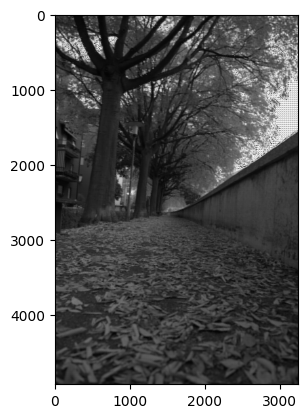

In [47]:
plt.imshow(reconstructed_output_image, cmap='gray')

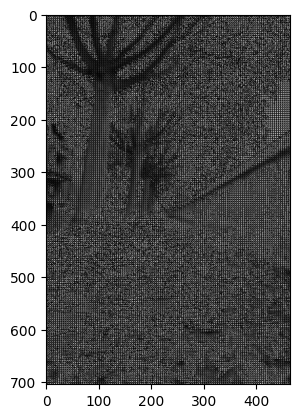

In [48]:
plt.imshow(reconstructed_compressed_output_image, cmap='gray')

In [50]:
# Aquí usamos el Image from PIL

im_original_to_save = im.fromarray(x_testing_reconstructed)
im_original_to_save.save('img_original.png')

im_compressed_to_save = im.fromarray(reconstructed_compressed_output_image)
im_compressed_to_save.save('img_compressed.png')

im_decompressed_to_save = im.fromarray(reconstructed_output_image)
im_decompressed_to_save.save('img_decompressed.png')